In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [53]:
path = '/Users/sunjiawen/Desktop/Advanced ts/lecture02_kernel_methods_approximate_pdf.txt'
data = pd.read_csv(path, header=None).to_numpy().flatten()
data


array([0.21912524, 0.37159598, 0.66222731, ..., 0.25076543, 0.45238561,
       0.6745316 ])

In [54]:
def indicator(y_t, y, h):
    return 1 if y - h < y_t < y + h else 0

def approximate_pro(y, data, h):
    indicators = [indicator(val, y, h) for val in data]
    return sum(indicators) / len(data)

def approximate_density(y, data, h):
    return approximate_pro(y, data, h) / (2 * h)

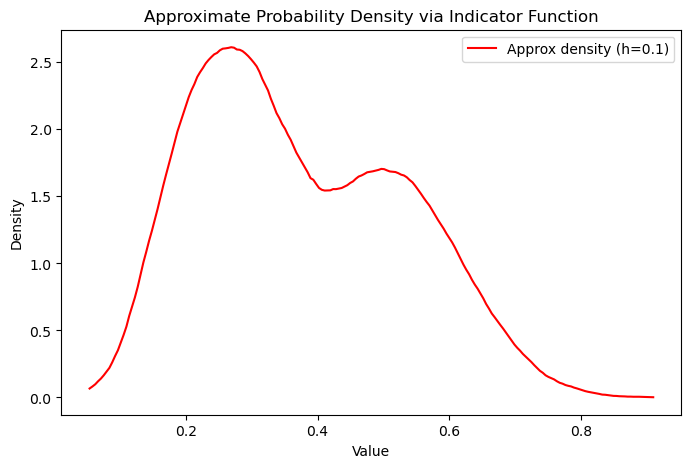

In [55]:
h = 0.1
ys = np.linspace(data.min(), data.max(), 200)

densities = [approximate_density(val, data, h) for val in ys]

plt.figure(figsize=(8,5))
plt.plot(ys, densities, 'r-', label=f"Approx density (h={h})")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Approximate Probability Density via Indicator Function")
plt.legend()
plt.show()


The thing I don't consider that histgram

The teacher choose h = 0.1 / 0.05 /0.01

grid is linspace(0,1,1e4)


In [56]:
path2 = '/Users/sunjiawen/Desktop/Advanced ts/lecture02_kernel_methods_conditional_mean.txt'
data2 = pd.read_csv(path2, header=None).to_numpy()
Y, Z = data2[:, 0], data2[:, 1]

In [57]:
def uniform_kernel(u):
    return 0.5 if -1 < u <= 1 else 0

def gaussian_kernel(u):
    return (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * u**2)

## Slide 9 - (16-17)
def approximate_conditional_expectation(data, h, kernel, G=lambda z: z):
    Y, Z = data[:, 0], data[:, 1]
    n = len(Y)
    estimates = np.zeros(n)

    for idx in range(n):
        y = Y[idx]
        weights = np.array([kernel((Y[i] - y) / h) for i in range(n)])
        weights_sum = np.sum(weights)
        if weights_sum == 0:
            estimates[idx] = np.nan
        else:
            estimates[idx] = np.sum(weights * G(Z)) / weights_sum

    return estimates

In [58]:
cond_mean = approximate_conditional_expectation(data2, h=0.1, kernel=uniform_kernel)


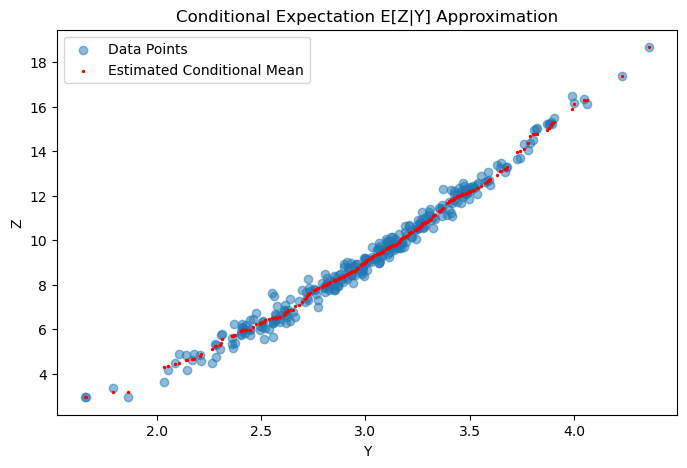

In [59]:
plt.figure(figsize=(8,5))
plt.scatter(Y, Z, alpha=0.5, label="Data Points")
plt.scatter(Y, cond_mean, color='red', label="Estimated Conditional Mean", s=2)
plt.xlabel("Y")
plt.ylabel("Z")
plt.title("Conditional Expectation E[Z|Y] Approximation")
plt.legend()
plt.show()

In [60]:
# Identification of functional relationship
def Model_A(time_series):
    X = np.zeros(time_series)
    esp = np.random.randn(time_series)
    for t in range(1, time_series):
        if X[t-1] > 0:
            X[t] = -0.8 * X[t-1] + esp[t]
        else:
            X[t] = 0.8 * X[t-1] + 1.5 + esp[t]
    
    return X

def Model_B(time_series):
    X = np.zeros(time_series)
    esp = np.random.randn(time_series)
    for t in range(1, time_series):
        X[t] = np.sqrt(1 + X[t-1]**2) * esp[t]
    
    return X

    

## For this part I don't think it is good. Because I don't match the graphs that the prof uploaded.

In [61]:
from scipy.stats import norm

In [ ]:
def product_kernel(x, X_lag, h):
    u = (x - X_lag) / h 
    K = np.prod(gaussian_kernel(u), axis=1)
    return K

def kernel_estimators(X, Y, h, grid):
    N, q = X.shape
    M = grid.shape[0]
    mean = np.zeros(M)
    var = np.zeros(M)

    if np.isscalar(h):
        h = np.full(q, h)

    for m in range(M):
        x = grid[m]
        weights = np.ones(N)

        for j in range(q):
            weights *= norm.pdf((x[j] - X[:, j]) / h[j])
        
        weights /= np.sum(weights)

        m_hat = np.sum(weights * Y)
        v_hat = np.sum(weights * (Y - m_hat)**2)
    
        mean[m] = m_hat
        var[m] = v_hat

    return mean, var




In [71]:
## 待测试
def kernel_estimators_t(X, h, lags, grid):
    X = np.asarray(X)
    N = len(X)
    d = len(lags)
    M = grid.shape[0]

    if np.isscalar(h):
        h = np.full(d, h)

    mean_hat = np.zeros(M)
    var_hat = np.zeros(M)

    i1 = lags[0]     # 最小滞后
    id_ = lags[-1]   # 最大滞后

    for m in range(M):
        x = grid[m]

        num_mean, den_mean = 0.0, 0.0
        num_var, den_var = 0.0, 0.0

        for s in range(id_, N):  # 有效区间
            # --- Product kernel ---
            w = 1.0
            for j, lag in enumerate(lags):
                w *= norm.pdf((x[j] - X[s - lag]) / h[j])

            # 均值分子分母
            num_mean += X[s] * w
            den_mean += w

            # 方差分子分母
            num_var += (X[s]**2) * w
            den_var += w

        # 按 PPT 公式进行归一化
        mean_hat[m] = (num_mean / (N - id_)) / (den_mean / (N - id_ + i1))
        var_hat[m]  = (num_var  / (N - id_)) / (den_var  / (N - id_ + i1))

    return mean_hat, var_hat


In [72]:
time_series = 500
h = 0.6

X_A = Model_A(time_series)
X_B = Model_B(time_series)

X_A_lag = X_A[:-1].reshape(-1, 1)
Y_A = X_A[1:]

X_B_lag = X_B[:-1].reshape(-1, 1)
Y_B = X_B[1:]

grid = np.linspace(-3, 3, 200)   # shape (200,)
grid_2d = grid.reshape(-1, 1)    

m_A, v_A = kernel_estimators_t(X_A_lag, h, [1], grid_2d)
m_B, v_B = kernel_estimators_t(X_B_lag, h, [1], grid_2d)

/var/folders/wz/_c02npqx5bq7s68f2g8kp9l40000gn/T/ipykernel_48436/1064484360.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean_hat[m] = (num_mean / (N - id_)) / (den_mean / (N - id_ + i1))
/var/folders/wz/_c02npqx5bq7s68f2g8kp9l40000gn/T/ipykernel_48436/1064484360.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_hat[m]  = (num_var  / (N - id_)) / (den_var  / (N - id_ + i1))


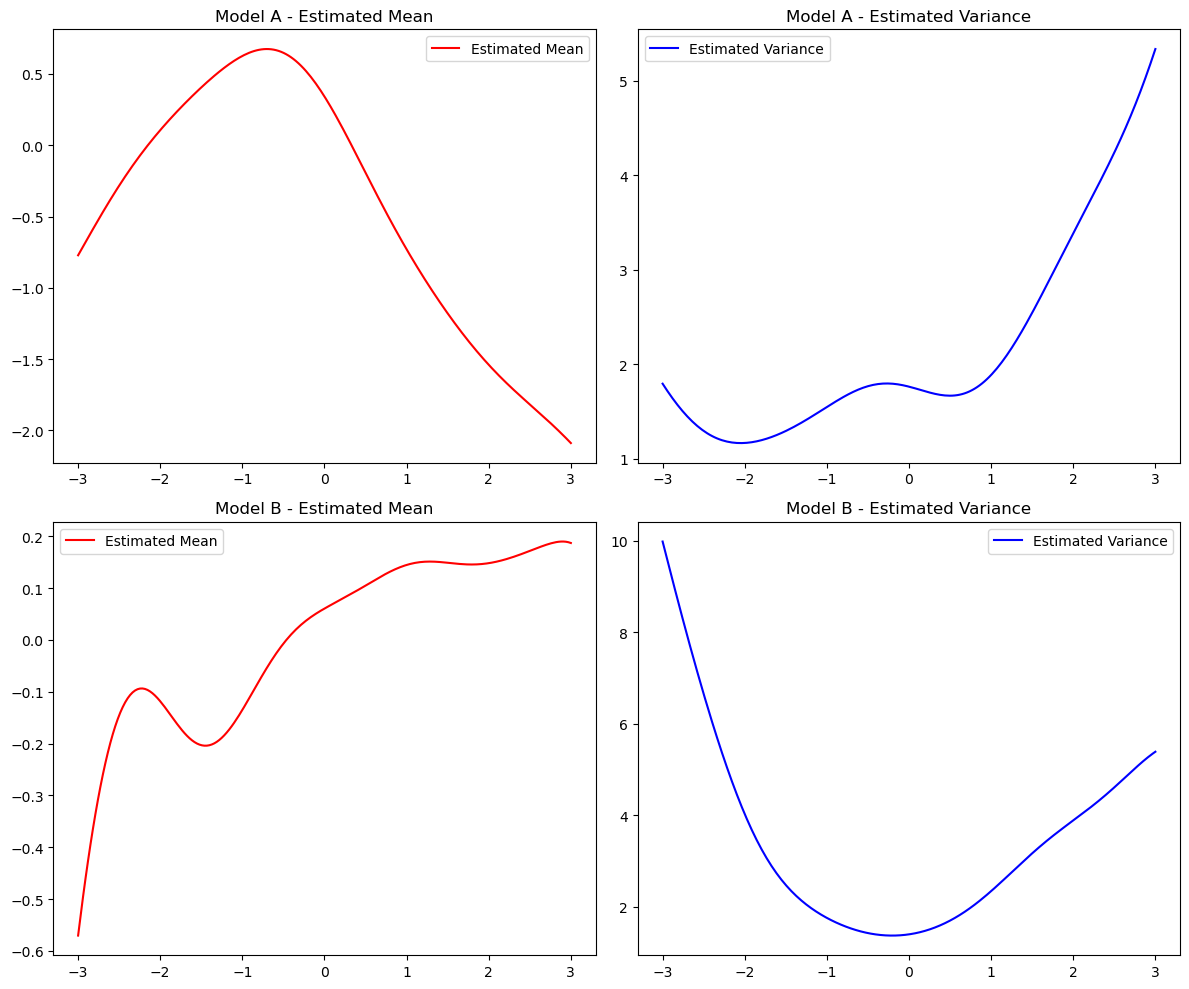

In [73]:

# ---------- Plot ----------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(grid, m_A, 'r-', label="Estimated Mean")
axs[0, 0].set_title("Model A - Estimated Mean")
axs[0, 0].legend()

axs[0, 1].plot(grid, v_A, 'b-', label="Estimated Variance")
axs[0, 1].set_title("Model A - Estimated Variance")
axs[0, 1].legend()

axs[1, 0].plot(grid, m_B, 'r-', label="Estimated Mean")
axs[1, 0].set_title("Model B - Estimated Mean")
axs[1, 0].legend()

axs[1, 1].plot(grid, v_B, 'b-', label="Estimated Variance")
axs[1, 1].set_title("Model B - Estimated Variance")
axs[1, 1].legend()

plt.tight_layout()
plt.show()


## In the final part，we also have a exe that need us to.